## **CLASIFICACIÓN DE IMÁGENES DE CÁNCER DE PULMÓN Y COLON**


Nota: el siguiente notebook fue ejecutado con una cuenta de Google Colab Pro debido al procesamiento de una gran cantidad de imágenes y gran dimensión.

In [28]:
#@title **Librerías**
import os
import gdown
from google.colab import drive
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, regularizers
import re
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import image_slicer
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#@title **Montar el Drive**
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
#@title **Descargar el dataset:** Obtener el conjunto de datos desde Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:41<00:00, 23.2MB/s]
100% 1.76G/1.76G [01:41<00:00, 18.7MB/s]


In [6]:
#@title Extraemos los archivos de su carpeta zip
!unzip lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

# En caso de no poder descargar el dataset desde Kaggle, seguir lo siguientes pasos:


1.   Ve a la página de tu cuenta en Kaggle (https://www.kaggle.com/[nombre-de-usuario]/account) y desplázate hacia abajo hasta la sección "API".
2.   Haz clic en el botón "Create New API Token". Esto descargará un archivo kaggle.json a tu dispositivo.
3.   Sube el archivo kaggle.json a la raiz de tu drive.
4.   Copia el path del archivo y agregalo en la variable file_path a continuación.
5. Ejecuta la siguiente serie de comandos.
6. Ahora podrás descargar el dataset desde Kaggle sin problemas.
7. Recuerda descomprimir el dataset luego de descargarlo.





In [4]:
# Copia aquí el path de tu archivo kaggle.json
file_path = '/content/drive/MyDrive/kaggle/kaggle.json'

!mkdir -p ~/.kaggle
!cp "$file_path" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


# **1. Método con las imágenes completas.**

In [7]:
#@title **Localización de carpetas con imágenes**
loc1 = '/content/lung_colon_image_set/colon_image_sets'
loc2 = '/content/lung_colon_image_set/lung_image_sets'

In [9]:
#@title **Se almacenan características**
features = []
limit_per_folder = 2500  # Número máximo de imágenes a almacenar por carpeta
for dir in os.listdir(loc1):
    sub_dir = os.path.join(loc1, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Contador de imágenes almacenadas por carpeta
    for img in tqdm(os.listdir(sub_dir)):
        if count >= limit_per_folder:  # Se alcanzó el límite de imágenes por carpeta
            break
        f = cv2.imread(os.path.join(sub_dir, img))
        f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY) #En caso de usar las imágenes en escala de grises
        f = cv2.resize(f , (250,250))
        features.append(f)
        count += 1



for dir in os.listdir(loc2):
    sub_dir = os.path.join(loc2, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Contador de imágenes almacenadas por carpeta
    for img in tqdm(os.listdir(sub_dir)):
        if count >= limit_per_folder:  # Se alcanzó el límite de imágenes por carpeta
            break
        f = cv2.imread(os.path.join(sub_dir, img))
        f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY) #En caso de usar las imágenes en escala de grises
        f = cv2.resize(f , (250,250))
        features.append(f)
        count += 1

/content/lung_colon_image_set/colon_image_sets/colon_aca
*************


 50%|█████     | 2500/5000 [00:19<00:19, 131.05it/s]


/content/lung_colon_image_set/colon_image_sets/colon_n
*************


 50%|█████     | 2500/5000 [00:20<00:20, 121.72it/s]


/content/lung_colon_image_set/lung_image_sets/lung_scc
*************


 50%|█████     | 2500/5000 [00:18<00:18, 135.21it/s]


/content/lung_colon_image_set/lung_image_sets/lung_aca
*************


 50%|█████     | 2500/5000 [00:16<00:16, 147.66it/s]


/content/lung_colon_image_set/lung_image_sets/lung_n
*************


 50%|█████     | 2500/5000 [00:16<00:16, 151.59it/s]


In [10]:
#@title **Se almacenan etiquetas**

labels = []
i = 0

for dir in os.listdir(loc1):
    sub_dir = os.path.join(loc1, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Variable de conteo
    for img in tqdm(os.listdir(sub_dir)):
        if count < 2500:  # Cargar solo las primeras 2500 imágenes
            labels.append(i)
            count += 1
        else:
            break  # Salir del bucle cuando se alcanza el límite
    i = i + 1

for dir in os.listdir(loc2):
    sub_dir = os.path.join(loc2, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Variable de conteo
    for img in tqdm(os.listdir(sub_dir)):
        if count < 2500:  # Cargar solo las primeras 2500 imágenes
            labels.append(i)
            count += 1
        else:
            break  # Salir del bucle cuando se alcanza el límite
    i = i + 1


/content/lung_colon_image_set/colon_image_sets/colon_aca
*************


 50%|█████     | 2500/5000 [00:00<00:00, 1966571.64it/s]


/content/lung_colon_image_set/colon_image_sets/colon_n
*************


 50%|█████     | 2500/5000 [00:00<00:00, 1938218.11it/s]


/content/lung_colon_image_set/lung_image_sets/lung_scc
*************


 50%|█████     | 2500/5000 [00:00<00:00, 2021546.17it/s]


/content/lung_colon_image_set/lung_image_sets/lung_aca
*************


 50%|█████     | 2500/5000 [00:00<00:00, 1394568.43it/s]


/content/lung_colon_image_set/lung_image_sets/lung_n
*************


 50%|█████     | 2500/5000 [00:00<00:00, 1886946.19it/s]


In [11]:
#@title **Características y Etiquetas**
X = np.array(features)
Y = np.array(labels)
print(X.shape)
print(Y.shape)

(12500, 250, 250)
(12500,)


In [12]:
#@title **Train Test Split de los datos**
xtrain,xtest,ytrain,ytest = train_test_split(X,Y, test_size=0.2, random_state=24)

In [13]:
#@title **Los pasamos a float32**
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')

In [14]:
#@title **Normalización de los datos**
xtrain = xtrain/xtrain.max()
xtest = xtest/xtest.max()

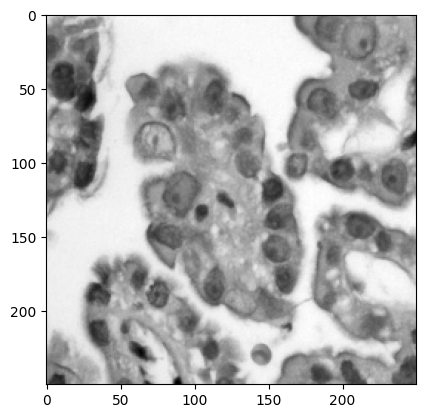

In [15]:
#@title **Imágen de ejemplo**
plt.imshow(xtrain[3],cmap='gray')
plt.show()

In [16]:
#@title *Se crea el modelo*
model = models.Sequential()

model.add(layers.Conv2D(32 ,(3,3) , padding = 'same' , input_shape = (250,250,1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(512 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(1024 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512 , activation='relu' ))
model.add(layers.Dense(5, activation='softmax') )

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      320       
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [18]:
#@title **Se compila el modelo**
sgd = tf.keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy' , optimizer=sgd , metrics=['accuracy'])

In [19]:
#@title **Entrenamiento del modelo**
history = model.fit(xtrain,ytrain,
         epochs=20,
         validation_split=0.1,verbose=True)

Epoch 1/20
282/282 [==============================] - 36s 77ms/step - loss: 1.0930 - accuracy: 0.4641 - val_loss: 1.0902 - val_accuracy: 0.4620
Epoch 2/20
282/282 [==============================] - 20s 72ms/step - loss: 0.6384 - accuracy: 0.7037 - val_loss: 0.4307 - val_accuracy: 0.8150
Epoch 3/20
282/282 [==============================] - 20s 72ms/step - loss: 0.4742 - accuracy: 0.7921 - val_loss: 0.4128 - val_accuracy: 0.8230
Epoch 4/20
282/282 [==============================] - 21s 73ms/step - loss: 0.3724 - accuracy: 0.8453 - val_loss: 0.3466 - val_accuracy: 0.8590
Epoch 5/20
282/282 [==============================] - 21s 73ms/step - loss: 0.2919 - accuracy: 0.8788 - val_loss: 0.2819 - val_accuracy: 0.8820
Epoch 6/20
282/282 [==============================] - 21s 73ms/step - loss: 0.2271 - accuracy: 0.9108 - val_loss: 0.2099 - val_accuracy: 0.9110
Epoch 7/20
282/282 [==============================] - 21s 73ms/step - loss: 0.2104 - accuracy: 0.9207 - val_loss: 0.3740 - val_accuracy:

In [20]:
#@title **Evaluación del modelo**
model.evaluate(xtest,ytest)

79/79 [==============================] - 2s 26ms/step - loss: 0.3692 - accuracy: 0.9168


[0.3691723048686981, 0.9168000221252441]

In [21]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'


    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

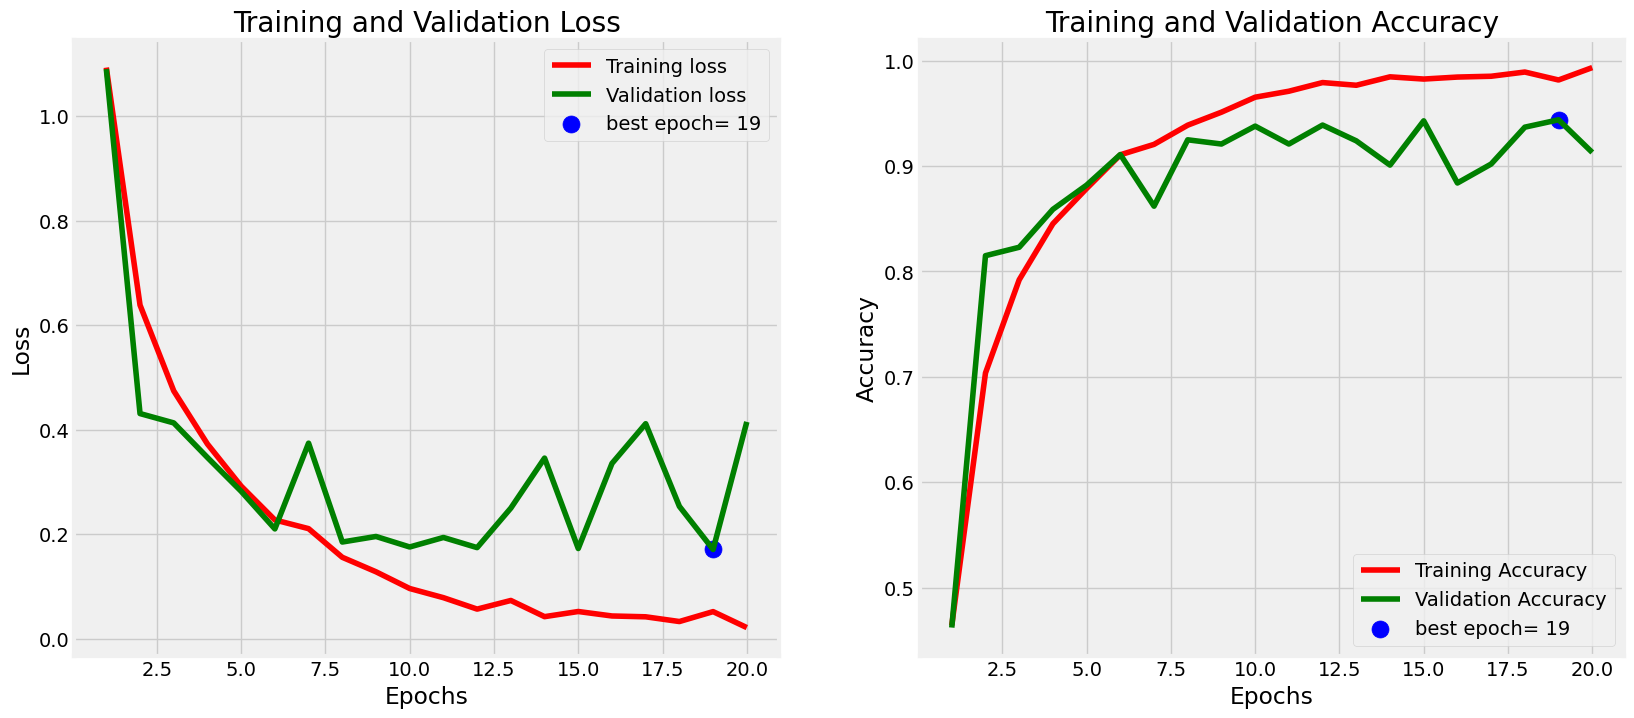

In [22]:
#@title **Gráfica del loss y el accuracy**
plot_training(history)

79/79 [==============================] - 2s 21ms/step


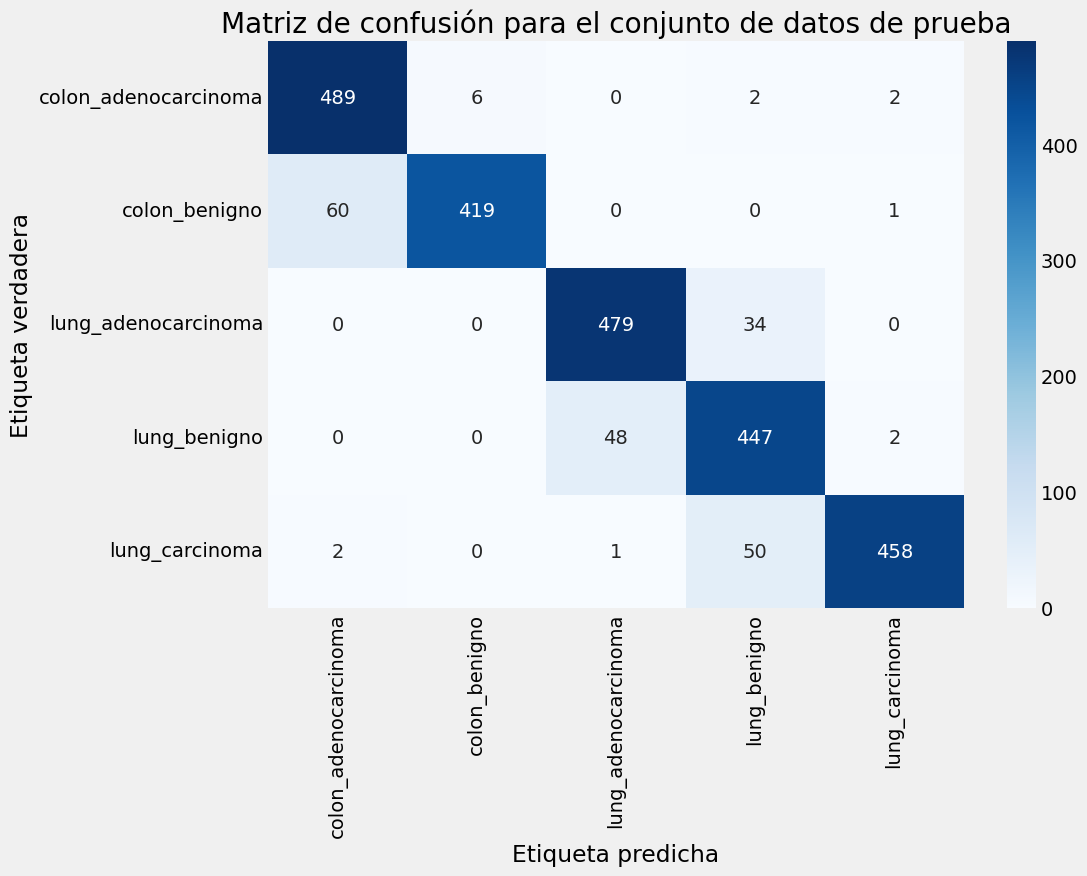

                      precision    recall  f1-score   support

colon_adenocarcinoma       0.89      0.98      0.93       499
       colon_benigno       0.99      0.87      0.93       480
 lung_adenocarcinoma       0.91      0.93      0.92       513
        lung_benigno       0.84      0.90      0.87       497
      lung_carcinoma       0.99      0.90      0.94       511

            accuracy                           0.92      2500
           macro avg       0.92      0.92      0.92      2500
        weighted avg       0.92      0.92      0.92      2500



In [23]:
#@title **Creamos la matríz de confusión**
y_true = ytest
y_pred = np.argmax(model.predict(xtest), axis=1)
cm = confusion_matrix(y_true, y_pred)

# Convertir la matriz en un dataframe
df_cm = pd.DataFrame(cm, index=["colon_adenocarcinoma", "colon_benigno", "lung_adenocarcinoma", "lung_benigno", "lung_carcinoma"], columns=["colon_adenocarcinoma", "colon_benigno", "lung_adenocarcinoma", "lung_benigno", "lung_carcinoma"])

# Crear el diagrama de calor
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión para el conjunto de datos de prueba")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.show()

# Obtener el informe de clasificación con métricas adicionales
target_names = ["colon_adenocarcinoma", "colon_benigno", "lung_adenocarcinoma", "lung_benigno", "lung_carcinoma"]
classification_rep = classification_report(y_true, y_pred, target_names=target_names)
print(classification_rep)


# **2. Método de parches:**

In [ ]:
!pip install image_slicer

In [27]:
#@title **Creamos los parches**
part_size = 240
input_base_dir = '/content/lung_colon_image_set/originales'
output_base_dir = '/content/lung_colon_image_set/nuevas'

def process_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for item in os.listdir(input_dir):
        item_path = os.path.join(input_dir, item)
        output_item_path = os.path.join(output_dir, item)

        if os.path.isdir(item_path):
            # Si es un subdirectorio, llamar recursivamente a la función
            process_images(item_path, output_item_path)
        else:
            # Si es un archivo de imagen, procesar y dividir las partes
            img = cv2.imread(item_path)

            # Redimensionar la imagen a un tamaño divisible por part_size
            height, width, _ = img.shape
            new_height = (height // part_size) * part_size
            new_width = (width // part_size) * part_size
            img = cv2.resize(img, (new_width, new_height))

            for r in range(0, new_height, part_size):
                for c in range(0, new_width, part_size):
                    r_end = r + part_size
                    c_end = c + part_size
                    output_path = os.path.join(output_dir, f"{item}_{r}_{c}.png")
                    cv2.imwrite(output_path, img[r:r_end, c:c_end, :])

# Llamar a la función para procesar las imágenes en los directorios
process_images(input_base_dir, output_base_dir)

In [29]:
loc1 = '/content/lung_colon_image_set/nuevas/colon_image_sets'
loc2 = '/content/lung_colon_image_set/nuevas/lung_image_sets'

In [30]:
#@title **Se almacenan características**
features = []
limit_per_folder = 4000 # Número máximo de imágenes a almacenar por carpeta
for dir in os.listdir(loc1):
    sub_dir = os.path.join(loc1, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Contador de imágenes almacenadas por carpeta
    for img in tqdm(os.listdir(sub_dir)):
        if count >= limit_per_folder:  # Se alcanzó el límite de imágenes por carpeta
            break
        f = cv2.imread(os.path.join(sub_dir, img))
        f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY) #En caso de usar las imágenes en escala de grises

        features.append(f)
        count += 1



for dir in os.listdir(loc2):
    sub_dir = os.path.join(loc2, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Contador de imágenes almacenadas por carpeta
    for img in tqdm(os.listdir(sub_dir)):
        if count >= limit_per_folder:  # Se alcanzó el límite de imágenes por carpeta
            break
        f = cv2.imread(os.path.join(sub_dir, img))
        f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY) #En caso de usar las imágenes en escala de grises
        features.append(f)
        count += 1

/content/lung_colon_image_set/nuevas/colon_image_sets/colon_aca
*************


  9%|▉         | 4000/45000 [00:15<02:36, 261.93it/s]


/content/lung_colon_image_set/nuevas/colon_image_sets/colon_n
*************


  9%|▉         | 4000/45000 [00:06<01:10, 583.90it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_scc
*************


  9%|▉         | 4000/45000 [00:14<02:30, 272.68it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_aca
*************


  9%|▉         | 4000/45000 [00:15<02:38, 258.05it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_n
*************


  9%|▉         | 4000/45000 [00:14<02:29, 273.86it/s]


In [31]:
#@title **Se almacenan etiquetas**
labels = []
i = 0

for dir in os.listdir(loc1):
    sub_dir = os.path.join(loc1, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Variable de conteo
    for img in tqdm(os.listdir(sub_dir)):
        if count < 4000:  # Cargar solo las primeras 2500 imágenes
            labels.append(i)
            count += 1
        else:
            break  # Salir del bucle cuando se alcanza el límite
    i = i + 1

for dir in os.listdir(loc2):
    sub_dir = os.path.join(loc2, dir)
    print(sub_dir)
    print('*************')
    count = 0  # Variable de conteo
    for img in tqdm(os.listdir(sub_dir)):
        if count < 4000:  # Cargar solo las primeras 2500 imágenes
            labels.append(i)
            count += 1
        else:
            break  # Salir del bucle cuando se alcanza el límite
    i = i + 1

/content/lung_colon_image_set/nuevas/colon_image_sets/colon_aca
*************


  9%|▉         | 4000/45000 [00:00<00:00, 1516241.84it/s]


/content/lung_colon_image_set/nuevas/colon_image_sets/colon_n
*************


  9%|▉         | 4000/45000 [00:00<00:00, 1501451.23it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_scc
*************


  9%|▉         | 4000/45000 [00:00<00:00, 1498099.47it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_aca
*************


  9%|▉         | 4000/45000 [00:00<00:00, 1917615.27it/s]


/content/lung_colon_image_set/nuevas/lung_image_sets/lung_n
*************


  9%|▉         | 4000/45000 [00:00<00:00, 2046251.49it/s]


In [32]:
#@title **Características y Etiquetas**
X = np.array(features)
Y = np.array(labels)
print(X.shape)
print(Y.shape)

(20000, 240, 240)
(20000,)


In [33]:
#@title **Train test split de los datos**
xtrain,xtest,ytrain,ytest = train_test_split(X,Y, test_size=0.2, random_state=24)

In [34]:
#@title **Los pasamos a float32**
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')

In [35]:
#@title **Normalización de los datos**
xtrain = xtrain/xtrain.max()
xtest = xtest/xtest.max()

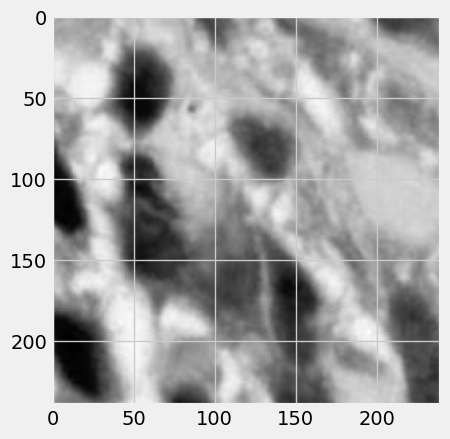

In [36]:
#@title **Imágen de ejemplo**
plt.imshow(xtrain[100],cmap='gray')
plt.show()

In [37]:
#@title **Se crea el modelo, esta vez con una entrada de 240x240**
model = models.Sequential()

model.add(layers.Conv2D(32 ,(3,3) , padding = 'same' , input_shape = (240,240,1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(512 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(1024 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512 , activation='relu' ))
model.add(layers.Dense(5, activation='softmax') )

In [38]:
#@title **Compilamos el modelo con un learning_rate más bajo**
sgd = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy' , optimizer=sgd , metrics=['accuracy'])

In [39]:
#@title **Entrenamos el modelo con un batch_size de 32**
early_stopping = EarlyStopping(patience=3)
history = model.fit(xtrain, ytrain,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=True,
                    callbacks=[early_stopping])

Epoch 1/20
450/450 [==============================] - 38s 75ms/step - loss: 0.9874 - accuracy: 0.4829 - val_loss: 0.9316 - val_accuracy: 0.5412
Epoch 2/20
450/450 [==============================] - 32s 72ms/step - loss: 0.7364 - accuracy: 0.6442 - val_loss: 0.6857 - val_accuracy: 0.6681
Epoch 3/20
450/450 [==============================] - 33s 73ms/step - loss: 0.6248 - accuracy: 0.7187 - val_loss: 0.6827 - val_accuracy: 0.6919
Epoch 4/20
450/450 [==============================] - 33s 72ms/step - loss: 0.5881 - accuracy: 0.7422 - val_loss: 0.7887 - val_accuracy: 0.6300
Epoch 5/20
450/450 [==============================] - 32s 72ms/step - loss: 0.5512 - accuracy: 0.7581 - val_loss: 0.4897 - val_accuracy: 0.7887
Epoch 6/20
450/450 [==============================] - 33s 72ms/step - loss: 0.5199 - accuracy: 0.7739 - val_loss: 0.5783 - val_accuracy: 0.7375
Epoch 7/20
450/450 [==============================] - 33s 73ms/step - loss: 0.4906 - accuracy: 0.7869 - val_loss: 0.4552 - val_accuracy:

In [40]:
#@title **Evaluamos el modelo**
model.evaluate(xtest,ytest)

125/125 [==============================] - 3s 21ms/step - loss: 0.3681 - accuracy: 0.8540


[0.36808866262435913, 0.8539999723434448]

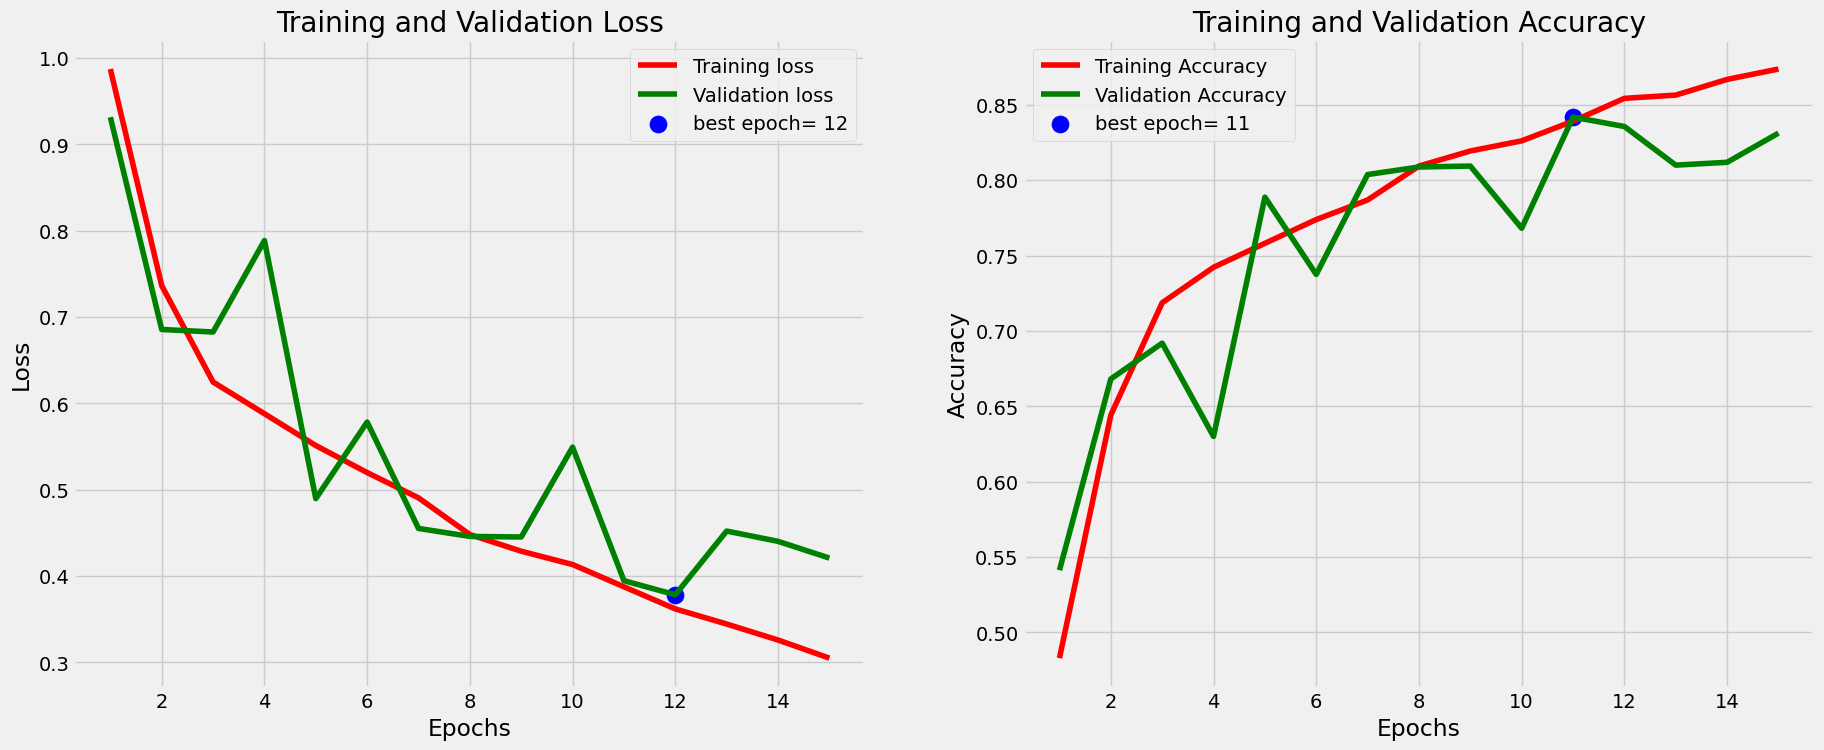

In [41]:
#@title **Gráfica del loss y el accuracy**
plot_training(history)

125/125 [==============================] - 2s 19ms/step


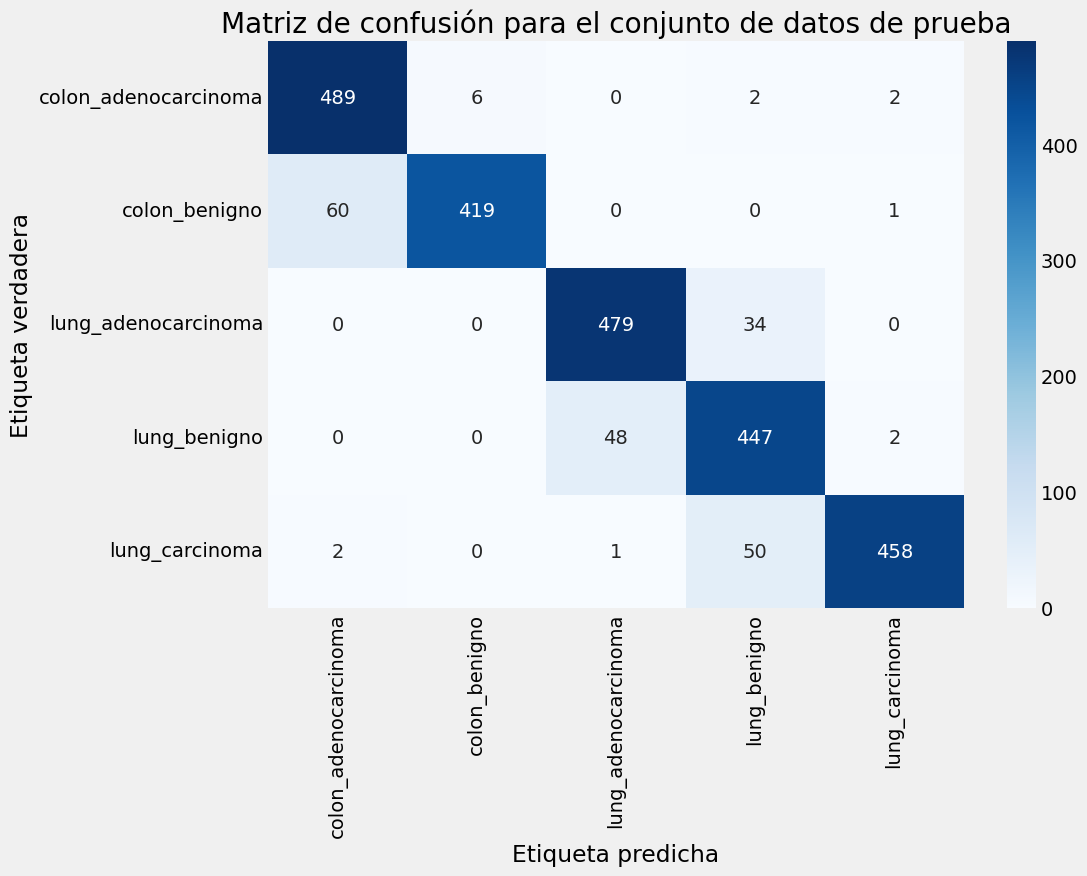

                      precision    recall  f1-score   support

colon_adenocarcinoma       0.83      0.97      0.89       761
       colon_benigno       0.97      0.81      0.88       824
 lung_adenocarcinoma       0.81      0.87      0.84       805
        lung_benigno       0.78      0.72      0.75       798
      lung_carcinoma       0.91      0.91      0.91       812

            accuracy                           0.85      4000
           macro avg       0.86      0.86      0.85      4000
        weighted avg       0.86      0.85      0.85      4000



In [43]:
#@title **Creamos la matríz de confusión**
y_true = ytest
y_pred = np.argmax(model.predict(xtest), axis=1)
cm = confusion_matrix(y_true, y_pred)
# Crear el diagrama de calor
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión para el conjunto de datos de prueba")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.show()
classification_rep = classification_report(y_true, y_pred, target_names=target_names)
print(classification_rep)